In [1]:
import numpy as np
import pandas as pd
import scipy

# Объявление функций

In [2]:
def read_data(filepath: str, offset: int = 0, data_length: int = None, data_type: str ='int16') -> pd.DataFrame:
    """Фукнция для считывания данных из бинарных файлов

    Args:
        filepath (str): Путь до файла.
        offset (int, optional): Количество наблюдений, которое нужно пропустить сначала. Defaults to 0.
        data_length (int, optional): Необходимое количество наблюдений. Если не передавать никакого значения, будут считаны все данные, начиная с offset. Defaults to None.
        data_type (str, optional): Тип данных. Defaults to 'int16'.

    Returns:
        pd.DataFrame: Итоговая таблица. Столбцы right, top, left, bottom отвечают за данные с четырех пикапов.
    """

    # Считывание данных в один вектор
    line_data = np.fromfile(filepath, dtype=data_type)
    # Разделение вектора на четыре столбца матрицы, каждый из которых соответствует пикапу
    data = line_data.reshape(-1, 4)
    # Формирование датафрейма на основе предыдущей матрицы
    data = pd.DataFrame(data, columns=['right', 'top', 'left', 'bottom'])
    # Если не передано никакого значения в data_length, то будут браться все значение, начиная с offset
    if data_length is None: data_length = len(data) - offset
    # Из полученного датафрейма делается срез, начиная с offset, длинной data_length. в котором сбрасываются индесы (чтобы они начинались с нуля)
    data = data.iloc[offset: offset + data_length].reset_index().drop('index', axis=1)
    return data

In [3]:
def fft_with_corrected_frequences(data: np.ndarray, corrected_frequences: np.ndarray, number_of_samples: int = 256, number_of_values: int = None) -> np.ndarray:
    """Прямое преборазование Фурье с учетом корректировочных частот

    Args:
        data (np.ndarray): Вектор данных
        corrected_frequences (np.ndarray): Вектор корректировочных частот
        number_of_samples (int, optional): Число отсчетов для преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 256.
        number_of_values (int, optional): Число итоговых знячений. По умолчанию, выводятся все. Defaults to None.

    Returns:
        np.ndarray: Преобразованный вектор
    """

    # Преобразование данных в формат np.ndarray для корректной работы
    data = np.array(data)
    # Если number_of_values не был задан, берутся все значение
    if number_of_values is None: number_of_values = len(data)
    # Реализация прямого преобразования Фурье с корректировочными частотами (2j означает 2 * мнимую единицу)
    return np.fromiter((data[:number_of_samples] @
            np.exp(2j * np.pi * corrected_frequences[i] * np.arange(number_of_samples))
            for i in range(number_of_values)), 'complex')

In [4]:
def find_period(data: np.ndarray, number_of_samples: int = 32*2048, sample_length: int = 10, period_correction: float = 0.005,
                number_of_amplitudes_for_corrected_period: int = 20, half_window_length: int = 5) -> float:
    """Поиск периода в данных с помощью преобразования Фурье со сглаживанием и корректировочными частотами

    Args:
        data (np.ndarray): Вектор данных
        number_of_samples (int, optional): Число отсчетов для преобразования Фурье. Defaults to 32*2048.
        sample_length (int, optional): Длина окна, в котором выполняется сглаживание методом среднего. Defaults to 10.
        period_correction (float, optional): Изменение периода, относительно которого происходит корректировка. Defaults to 0.005.
        number_of_amplitudes_for_corrected_period (int, optional): Число амплитуд после второй корректировки. Defaults to 21.
        half_window_length (int, optional): Дляга полуокна, в котором будет производится регрессия. Defaults to 5.

    corrected_signaleturns:
        float: Значение периода
    """

    # Перевод данных в формат np.ndarray для корректной работы
    data = np.array(data)
    # Разделение данных на numer_of_samples участков по sample_length значений для последующего сглаживания
    sampled_data = data[:(number_of_samples * sample_length)].reshape(-1, sample_length)
    # Сглаживание данных на каждом из участков посредством усреднения
    smoothed_data = pd.DataFrame(sampled_data.T).mean().to_numpy()
    # Применение прямого преобразования Фурье для сглаженных данных. Нахождение амплитуд
    fourier_decomposition_amplitudes = np.abs(scipy.fft.fft(smoothed_data, norm='forward'))
    # Нахождение несущей частоты для полученных амплитуд
    carrier_frequency = np.argmax(fourier_decomposition_amplitudes)
    # Проверка на неравенство несущей частоты нулю
    if carrier_frequency == 0: raise ValueError("Incorrect_data. Carrier frequency can't be zero")
    # Нахождения периода в данных после сглаживания
    period_after_smoothing = number_of_samples * sample_length / carrier_frequency
    # Нахождение корректировочных периодов
    corrected_periods = period_after_smoothing * (1 + period_correction * (2*np.arange(number_of_amplitudes_for_corrected_period + 1)
                                                                           / number_of_amplitudes_for_corrected_period - 1)) # Уточненные периоды для каждого окна
    # Применение прямого преобразования Фурье к данным с учетом корректировочных периодов. Нахождение амплитуд
    fourier_decomposition_amplitudes_with_corrected_periods = 1 / (number_of_samples * sample_length) *\
        np.abs(fft_with_corrected_frequences(data, 1 / corrected_periods,
                                      number_of_samples*sample_length,
                                      number_of_amplitudes_for_corrected_period))
    # Нахождение несущей частоты  (или несущего периода) для полученных на предыдущем шаге амплитудах
    carrier_frequency_in_corrected_spectrum = np.argmax(fourier_decomposition_amplitudes_with_corrected_periods)
    # Нахождение значений отклонений от несущего периода. В данном случае, в обе стороны откладывается по half_window_length значений
    deviations_form_carrier_period_slice = corrected_periods[carrier_frequency_in_corrected_spectrum-half_window_length:
                                                             carrier_frequency_in_corrected_spectrum+half_window_length+1] -\
                                            carrier_frequency_in_corrected_spectrum
    # Аналогично, берется такое же окно для амплитуд.
    fourier_decomposition_amplitudes_with_corrected_periods_slice =\
        fourier_decomposition_amplitudes_with_corrected_periods[carrier_frequency_in_corrected_spectrum-half_window_length:
                                                                carrier_frequency_in_corrected_spectrum+half_window_length+1]
    # Построение квадратичной регрессии по отклонениям и амплитудам
    square_regressions_coefficients = np.polyfit(deviations_form_carrier_period_slice,
                                                fourier_decomposition_amplitudes_with_corrected_periods_slice, 2)
    # Нахождение итогового периода в данных
    data_period = carrier_frequency_in_corrected_spectrum - (square_regressions_coefficients[1]) / (2 * square_regressions_coefficients[0])

    return data_period

In [5]:
def get_beam_center_positions(summary_resonace: np.ndarray, difference_resonance: np.ndarray, period_length: float) -> np.ndarray:
    """Фукнция для вычисления координат центра масс по заданным суммарным и разностным резонансом для одной из осей.

    Args:
        summary_resonace (np.ndarray): Вектор суммарных резонансов по одной из осей.
        difference_resonance (np.ndarray): Вектор разностных резонансов по той же самой оси.
        period_length (float): Длина периода. Может быть дробной.

    Returns:
        np.ndarray: Вектор со значениями координаты центра масс для каждого из периодов по заданной оси.
    """

    # Вычисление общего количества периодов
    number_of_periods = int(len(summary_resonace) / period_length)
    # Задания вектора, с количеством элементов, равным числу периодов, для хранения полученных координат. Изначально заполнен нулями
    mass_center_positions = np.zeros(number_of_periods)
 
    # Запускаем цикл от 0 до number_of_periods-1 включительно с шагом 1. Грубо говоря, этим циклом мы пробегаемся по всем периодам
    for i in range(number_of_periods):

        # Находим срез, соответсвующий текущему периоду, для векторов summary_resonance и difference_resonance.
        # ВАЖНАЯ ДЕТАЛЬ. В данном случае, вручную задается тип int64, так как происходит переполнение изначального типа int16 при возведении значений в квадрат
        summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length): int((i+1)*period_length)] 
        difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length): int((i+1)*period_length)] 
 
        # Вычисление промежуточных параметров. Автор не особо осведомлен об их природе, поэтому тут могут потребоваться дополнительные пояснения
        m_11 = float(np.sum(summary_resonance_period_slice**2))
        m_12 = float(np.sum(summary_resonance_period_slice)) 
 
        y_1 = float(summary_resonance_period_slice @ difference_resonance_period_slice) 
        y_2 = float(np.sum(difference_resonance_period_slice)) 

        # Вычисление значения координаты центра масс для текущего периода. Добавление ее в итоговый вектор
        mass_center_positions[i] = ((m_12 * y_2) - (np.floor(period_length) * y_1)) / (m_12 ** 2 - m_11 * np.floor(period_length)) 
 
    return mass_center_positions

In [6]:
# WARNING!!! Данная функция пока еще не была протестирована для правой части спектра
def get_spectrum(signal: np.ndarray, time_delta: float = 1, number_of_samples: int = 2**8, offset: int = 0, is_left_part: bool = True) -> tuple:
    """Функция для нахождения спектра.

    Args:
        signal (np.ndarray): Вектор значений сигнала.
        time_delta (float): Значение шага по времени. Defaults to 1.
        number_of_samples (int, optional): _description_. Число отсчетов для дискретного преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 2**8.
        offset (int, optional): _description_. Количество частот, которые мы пропускаем сначала (т.е. считаем их амплитуду нулевой). Defaults to 0.
        is_left_part (bool, optional): _description_. Флаг, отвечающий за интересующую часть спектра. Если True - берется левая часть спектра (частота меньше 0.5).
            Если False - правая (частота больше 0.5). Defaults to True.

    Returns:
        tuple: Возвращает кортеж с двумя векторами типов np.ndarray: frequences - значения частот, amplitudes - значения соответствующих им амплитуд.
    """

    # Применяем прямое преобразование Фурье для первый number_of_samples сигналов. Для получения нужной нормировки, делим на number_of_samples
    fourier_transformed_vector = scipy.fft.fft(np.array(signal)[:number_of_samples]) / number_of_samples
    # Заполняем первые offset значений нулями и оставляем только первую половину значений от преобразованного вектора. В дальнейшем, если будет нужна правая часть, это преобразуется
    sliced_fourier_transformed_vector = np.concatenate([np.zeros(offset), fourier_transformed_vector[offset: number_of_samples // 2]])
    # Находим амплитуды сигналов, находя абсолютные значения для каждой из величин преобразованного вектора
    amplitudes = np.abs(sliced_fourier_transformed_vector)
    # Находим шаг, с которым будем вычислять частоты
    frequences_step = 1 / (number_of_samples*time_delta)
    # С помощью данного ветвления происходит выбор между правой и левой частями спектра
    if is_left_part:
        # Если левая часть спектра, то частоты берутся от 0 до 0.5
        frequences = np.arange(0, 1/(2*time_delta), frequences_step)
    else:
        # WARNING!!! Данная часть не тестировалась. Возможные ошибки:
        # 1. Неправильный порядок частот или амплитуд. Можно попытаться отразить порядок следования элементов в массиве. Например, amplitudes = amplitudes[::-1].
        # 2. Небольшое смещение частот. Для этого, при расчете frequences нужно убрать слагаемое "+ frequences_step"

        # Если правая часть спектра, то сначала нужно преобразовать амплитуды
        amplitudes = 1 - amplitudes
        # Частоты берутся от 0.5 до 1
        frequences = np.arange(1/(2*time_delta), 1/time_delta, frequences_step) + frequences_step

    return frequences, amplitudes

In [7]:
def find_main_frequence(frequences: np.ndarray, amplitudes: np.ndarray, slice_percentage: float = 0.5) -> float:
    """Функция для нахождения основной частоты спектра.

    Args:
        frequences (np.ndarray): Вектор частот спектра.
        amplitudes (np.ndarray): Вектор амплитуд спектра.
        slice_percentage (float, optional): Параметр, отвечающий за долю значений, которые будут расматриваться (автор не до конца в этом уверен)/
            По умолчанию, берутся все значения. Defaults to 0.5.

    Raises:
        ValueError: Возникает, если frequences и amplitudes имеют разную длину.

    Returns:
        float: Значение основной частоты
    """

    # Проверка на соответствие длин frequences и amplitudes. При несоответсвии выдается исключение
    if len(frequences) != len(amplitudes):
        raise ValueError('frequences and amplitudes must have same length')
    
    # Находим позицию, на которой находится значение максимальной из амплитуд вместе с соотвествующим срезом (умножение на двойку было в маткадовском коде,
    # если его убрать, то значение по умолчанию для slice_percentage нужно сделать равным единице).
    main_frequence_index = np.argmax(amplitudes[:int(slice_percentage * 2 * len(frequences))])
    # Выделяем частоту, которая находится на найденной выше позиции.
    main_frequence = frequences[main_frequence_index]
    return main_frequence

In [8]:
def damped_oscillations_fit(x_data: np.ndarray, y_data: np.ndarray, bounds: dict = None) -> tuple:
    """Подгоняет данные под функцию затухающих колебаний вида: A * exp(-beta * x) * cos(omega*x + phi) + bias

    Args:
        x_data (np.ndarray): Вектор данных для оси абцисс
        y_data (np.ndarray): Вектор данных для оси ординат
        bounds (dict, optional): Граничные условия для параметров. По умолчанию следующие:
                                    {'A': (0, np.inf), 'omega': (-np.inf, np.inf),
                                    'phi': (0, 2*np.pi), 'beta': (0, np.inf), 'bias': (-np.inf, np.inf)}.
                                 Для их задания нужно передать в функцию словарь такого же вида, где левое и правое значение
                                 в каждом из кортежей означают максимально и минимально возможные значение. Если какой-то параметр
                                 будет пропущен, он автоматически заменится значением по умолчанию. Для задания бесконечных границ
                                 следует использовать np.inf и -np.inf для +∞ и -∞ соответственно.Defaults to None.

    Returns:
        function: Итоговая фукнция, которая вызываетсяследующим образом: function(t)
        dict: Словарь со значениями параметров. Ключи: {'A', 'omega', 'phi', 'beta', 'bias'}
    """

    # Значения границ по умолчанию
    default_bounds = {'A': (0, np.inf), 'omega': (-np.inf, np.inf),
                    'phi': (0, 2*np.pi), 'beta': (0, np.inf), 'bias': (-np.inf, np.inf)}
    # Если параметр bounds в функцию не передавался, то он заменяется значением по умолчанию
    if bounds is None: bounds = default_bounds
    # Формирование пустого двухуровневого списка, размером 2 на 5, для формирования граничных условий в приемлемом для оптимизатора виде
    bounds_list = [[0]*5, [0]*5]
    # Цикл, в котором происходит заполнение списка
    for i, parameter_name in enumerate(('A', 'omega', 'phi', 'beta', 'bias')):
        # Если какой-то из параметров отсутсвует в словаре, он заменяется значением по умолчанию
        if parameter_name not in bounds: bounds[parameter_name] = default_bounds[parameter_name]
        # Заполнение списка граничными условиями
        bounds_list[0][i] = bounds[parameter_name][0]
        bounds_list[1][i] = bounds[parameter_name][1]
    # Функция гармонических колебаний с параметрами, нужная для последующего фитирования
    damped_oscillations_function = lambda t, A, omega, phi, beta, bias: A * np.exp(-beta*t) * np.cos(omega*t + phi) + bias
    # Проведение фитирования, извлечение параметров
    A, omega, phi, beta, bias = scipy.optimize.curve_fit(damped_oscillations_function, x_data, y_data, bounds=bounds_list)[0]
    # Формирование результирующей функции
    result_function = lambda t: A * np.exp(-beta*t) * np.cos(omega*t + phi) + bias
    # Формирование словаря с итоговыми параметрами
    parameters = {'A': A, 'omega': omega, 'phi': phi, 'beta': beta, 'bias': bias}
    return result_function, parameters

In [9]:
def pseudo_gaussian_exponent_approximation(chromacity: float, delta_impulse: float, approximation_range: float,
                                           accuracy: float = 0.01, sigma_bounds: tuple=(0, np.inf)) -> tuple:
    """Находит функцию вида exp(-x**2 / (2*sigma ** 2)), аппроксимирующую функцию sin(2*pi*chromacity*delta_impulse*x)/(2*pi*chromacity*delta_impulse*x))

    Args:
        chromacity (float): Хроматичность
        delta_impulse (float): Значение величины dp/p_0
        approximation_range (float): Правая граница промежутка аппроксимации (левая всегда равна 0)
        accuracy (float, optional): Точность задания сетки. Defaults to 0.01.
        sigma_bounds (tuple, optional): Граничные условия для параметра sigma. Задаются кортежем вида (min_sigma, max_sigma). Defaults to (0, np.inf).

    Returns:
        function: Итоговая функция вида exp(-x**2 / (2*sigma ** 2))
        function: Изначальная функция вида sin(2*pi*chromacity*delta_impulse*x)/(2*pi*chromacity*delta_impulse*x)
        float: Значение параметра sigma 
    """

    # Множитель перед x в функции с синусом
    multiplier = 2 * np.pi * chromacity * delta_impulse
    # Изначальная функция с синусом
    initial_function = lambda x: np.sin(multiplier * x) / (multiplier * x)
    # Целевая функция с параметром
    target_function = lambda x, sigma: np.exp(-x**2 / (2*sigma**2))
    # Формирование данных для обучения. Немного отступаем от нуля, чтобы избежать деления на 0
    x = np.arange(0.01, approximation_range, accuracy)
    y = initial_function(x)
    # Нахождение парметра через оптимизацию
    sigma = scipy.optimize.curve_fit(target_function, x, y, bounds=sigma_bounds)[0][0]
    # Результирующая функция в явном виде
    result_function = lambda x: np.exp(-x**2 / (2*sigma**2))
    return result_function, initial_function, sigma

In [10]:
def bunch_fft(data: np.ndarray, period: float) -> np.ndarray:
    """Делит вектор данных на периоды и применяет преборазование Фурье для каждого из них

    Args:
        data (np.ndarray): Вектор данных
        period (float): Значение периода (может быть дробным)

    Returns:
        np.ndarray: Матрица преобразованных данных. Каждая строка отвечает за один из периодов
    """

    # Преобразование данных для избежания некорректной работы
    data = np.array(data)
    # Вычисление общего числа периода
    number_of_periods = int(len(data) / period)
    # Создание матрицы, в которой будет сохранен итоговый результат
    fourier_transformed_bunches = np.zeros((number_of_periods, int(period)), dtype=complex)
    # Цикл по всем периодам    
    for i in range(number_of_periods):
        # Делаем срез данных, соответсвующий текущему периоду
        data_bunch = data[int(i*period): int((i+1)*period)]
        # Применяем преобразование Фурье к этому срезу и заносим результат в матрицу. Число значений всегда берем, как период, округленный в меньшую сторону
        fourier_transformed_bunches[i] = scipy.fft.fft(data_bunch, int(period), norm='forward')
    return fourier_transformed_bunches

In [11]:
def restore_original_signal_frequency_domain(signal: np.ndarray, period: float, rotation_frequency: float, transfer_function) -> np.ndarray:
    """Восстановлене исходного сигнала в частотной области

    Args:
        signal (np.ndarray): Вектор сигналов
        period (float): Значение периода (может быть дробным)
        rotation_frequency (float): Частота одного оборота
        transfer_function (function): Передаточная функция. Должна вызываться, как transfer_function(frequences)

    Returns:
        np.ndarray: Матрица с восстановленным сигналом, разделенным по периодам
    """

    # Применяем преобразование Фурье с разделением на периоды
    fourier_transformed_bunches = bunch_fft(signal, period)
    # Находим спектр частот в соответсвтии с заданной частотой оборота
    frequences_spectrum = np.arange(1, int(period)//2 + 1) * rotation_frequency
    # Для дальнейшиз расчетов, найдем половину длины периода (если он нечетная, округлится в меньшую стороны)
    half_period_length = len(frequences_spectrum)
    # Задаем итоговую матрицу, изначально просто копируя в нее преобразованную по Фурье матрицу
    restored_signal = fourier_transformed_bunches[:]
    # Запускаем цикл по всем периодам
    for i in range(len(restored_signal)):
        # Обрабатываем первую половину сигнала на данном периоде (самое первое значение в рассмотрение не берем)
        restored_signal[i][1:half_period_length+1] /= transfer_function(frequences_spectrum)
        # Обрабатываем вторую половину. В случае, если значение периода четное, то центральное значение учтется два раза
        if half_period_length % 2 == 0:
            restored_signal[i][:half_period_length-1:-1] /= transfer_function(frequences_spectrum).conjugate()
        else:
            restored_signal[i][:half_period_length:-1] /= transfer_function(frequences_spectrum).conjugate()

    return restored_signal

In [12]:
def restore_original_signal_time_domain(signal: np.ndarray, period: float, rotation_frequency: float, transfer_function) -> np.ndarray:
    """Восстановлене исходного сигнала во временной области

    Args:
        signal (np.ndarray): Вектор сигналов
        period (float): Значение периода (может быть дробным)
        rotation_frequency (float): Частота одного оборота
        transfer_function (function): Передаточная функция. Должна вызываться, как transfer_function(frequences)

    Returns:
        np.ndarray: Матрица с восстановленным сигналом, разделенным по периодам
    """

    # Восстановление сигнала изначально во временной области
    frequency_domain_restored_signal = restore_original_signal_frequency_domain(signal, period, rotation_frequency, transfer_function)
    # Создание матрицы для записи итогового результата
    time_domain_restored_signal = np.zeros_like(frequency_domain_restored_signal, float)
    # Запуск цикла по всем периодам
    for i in range(len(time_domain_restored_signal)):
        # Применение обратного преобразования Фурье к участку сигнала на периоде. Запись действительных частей в строку матрицы
        time_domain_restored_signal[i] = scipy.fft.ifft(frequency_domain_restored_signal[i], norm='forward').real
    
    return time_domain_restored_signal

In [13]:
def correct_offset_with_smoothing(bunched_signal: np.ndarray, smoothing_window_length: int) -> np.ndarray:
    """Коррекитровка оффсета сигнала с применением сглаживания, методом среднего

    Args:
        bunched_signal (np.ndarray): Матрица сигнала, разделенного на периоды. Каждая строка матрицы должна отвечать за период
        smoothing_window_length (int): Длина окна сглаживания

    Returns:
        np.ndarray: Матрица преобразованного сигнала, разделенного по периодам
    """

    # Создание матрицы для хранения итогового результата
    corrected_signal = np.zeros_like(bunched_signal)
    # Запускаем цикл по всем периода. В переменной i хранится номер периода, а в bunch - вектор значений периода
    for i, bunch in enumerate(bunched_signal):
        # Алгоритм для поиска минимального из средних по всем окнам
        minimal_mean = np.inf
        for j in range(len(bunch)-smoothing_window_length):
            # В данном, случае, +1, вообще говоря, не нужен, но без него значения не соответствовали маткадовским
            mean = np.mean(bunch[j:j+smoothing_window_length+1])
            if mean < minimal_mean: minimal_mean = mean
        # Отнимаем минимальное среднее на данном периоде от каждого из значений сигнала на периода
        corrected_signal[i] = bunch - minimal_mean
    return corrected_signal

# Пример реализации кода

## Подключение библиотек для рисования графиков

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_theme() # Установка более красивой темы для графиков

## Задание стартовых переменных и загрузка данных

Параметры считывания данны: offset - количество пропускаемых сначала значений, len_data - количество необходимых значений. Следует понимать, что в данном случае все данные изначально делятся на 4 столбца и после этого считается количество строк, которые нужно пропустить и отобрать. Таким образом, эти величины должны быть в 4 раза меньше по сравнению с тем, если бы все отбиралась из изначального одномерного вектора, как это реализовано в маткаде.

In [15]:
offset = 8 * 6300 // 2 // 4
len_data = 4 * 1024**2 // 4

Формирования словаря, в котором хранятся размеры пластинки по каждой из осей

In [16]:
plate_size = {}
plate_size['X'] = 64
plate_size['Y'] = 33
plate_size

{'X': 64, 'Y': 33}

Задание пути, по которому хранятся исходные данные

In [17]:
filepath = r'bpm_data/11_01_booster_libera08_hbpm3_1_full'

Загрузка данных

In [18]:
data = read_data(filepath, offset=offset, data_length=len_data)
data

,right,top,left,bottom
0,-147,-273,-406,79
1,-157,-196,-416,321
2,17,-124,-416,383
3,373,-29,-415,230
4,247,-82,-421,-149
...,...,...,...,...
1048571,496,365,32,438
1048572,526,141,228,682
1048573,614,271,132,356
1048574,486,376,130,-11


## Нахождение координат центров масс

Вычисление суммарных и разностных резонансов для каждой из осей

In [19]:
summary_resonance = pd.DataFrame()
summary_resonance['X'] = data['right'] + data['left']
summary_resonance['Y'] = data['top'] + data['bottom']

difference_resonance = pd.DataFrame()
difference_resonance['X'] = data['right'] - data['left']
difference_resonance['Y'] = data['top'] - data['bottom']

Нахождение периода. В данном случае, для суммарных резонансов по оси Ox

In [20]:
period = find_period(summary_resonance['X'])
period

2128.751497045826

Нахождение координат центров масс пучка для каждого из периодов по каждой из осей

In [21]:
beam_center_coords = pd.DataFrame()
for axis in ['X', 'Y']:
    beam_center_coords[axis] = plate_size[axis] * get_beam_center_positions(summary_resonance[axis], difference_resonance[axis], period)
beam_center_coords

,X,Y
0,1.303567,1.448332
1,-0.643356,1.535053
2,-2.574663,-0.158554
3,-4.874315,-1.920665
4,-4.766045,-2.940025
...,...,...
487,2.466626,1.702055
488,-3.553345,-0.141895
489,-1.755157,0.474462
490,1.770417,-0.924300


Построение гистограммы распределений координат центров масс

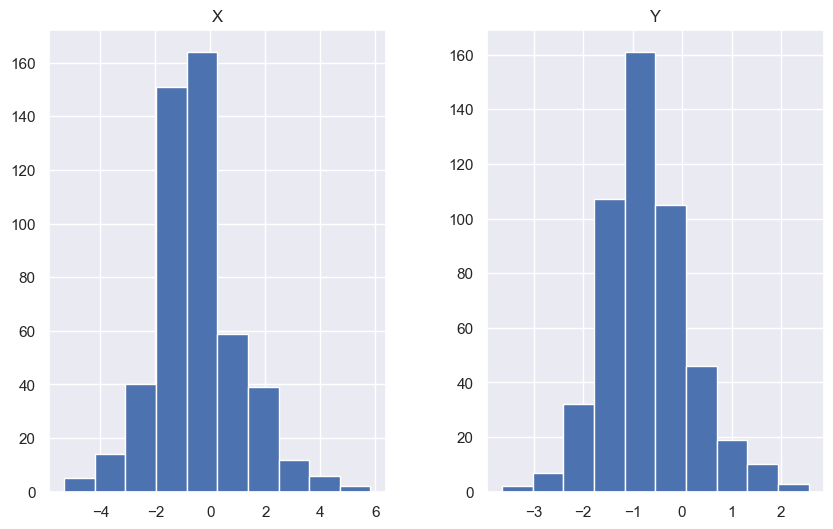

In [22]:
beam_center_coords.hist(figsize = (10, 6));

## Хроматичность

Нахождение спектра и основных часот для каждой из осей

In [23]:
spectrum = pd.DataFrame()
main_frequences = {}

for axis in 'X', 'Y':
    freq, amp = get_spectrum(beam_center_coords[axis], offset=3)
    spectrum[axis + ' amplitudes'] = amp
    main_frequences[axis] = find_main_frequence(freq, amp)

spectrum['frequences'] = freq
spectrum = spectrum.set_index('frequences')
spectrum

,X amplitudes,Y amplitudes
frequences,,
0.000000,0.000000,0.000000
0.003906,0.000000,0.000000
0.007812,0.000000,0.000000
0.011719,0.015387,0.025286
0.015625,0.036173,0.017706
...,...,...
0.480469,0.051900,0.025764
0.484375,0.010558,0.024299
0.488281,0.059366,0.007955


Построение графиков спектров с указанием на них основных частот

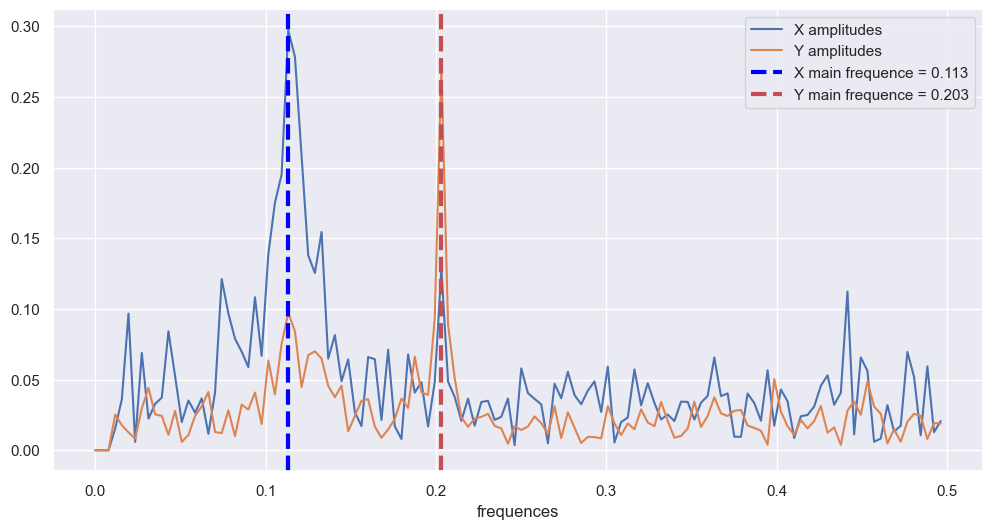

In [24]:
spectrum.plot(figsize=(12, 6))
plt.axvline(main_frequences['X'], ls='--', c='blue', lw=3, label=f'X main frequence = {round(main_frequences["X"], 3)}')
plt.axvline(main_frequences['Y'], ls='--', c='r', lw=3, label=f'Y main frequence = {round(main_frequences["Y"], 3)}')
plt.legend();

Будем аппроксимировать координаты центров масс функцией затухающих колебаний вида
$$y = Ae^{-\beta t}cos(\omega x + \varphi) + b$$
Смещение нужно по той причине, что детекторы могут быть не до конца откалиброваны

Изобразим на графике положения цетров масс для каждой из осей

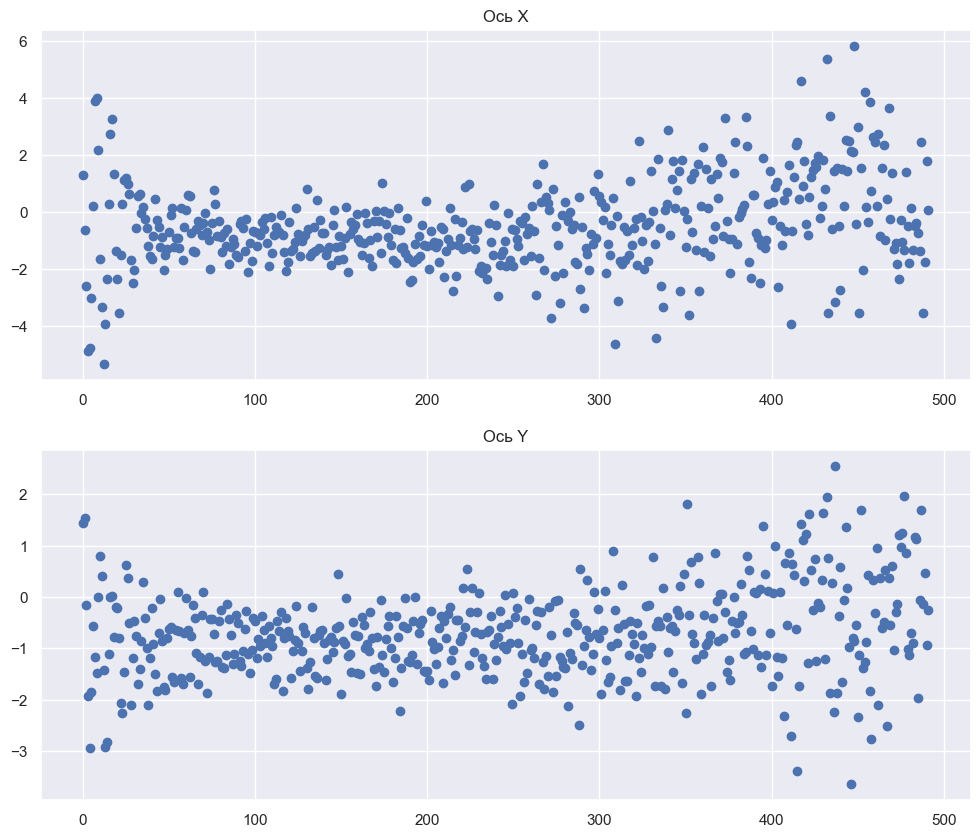

In [25]:
t = np.arange(492)
fig, axs = plt.subplots(2, figsize=(12, 10))
axs[0].scatter(t, beam_center_coords['X'])
axs[0].set_title('Ось X')
axs[1].scatter(t, beam_center_coords['Y'])
axs[1].set_title('Ось Y');

В данном случае видно,что затухающие колебания оканчиваются примерно на 100-ом значении для каждой из осей. Зададим словарь, в который введем значения срезов

In [26]:
slice_length = {'X': 100, 'Y': 100}

Зададим граничные условия для нашей функции. В данном случае, для частоты сделаем допустимым отклонение в 0.01 от основной. Также, искуственно ограничим амплитуды и коэффициент затухания для оси Y. Эти значения были подогнаны экспериментально после нескольких попыток

In [27]:
bounds = {
    'X': {'omega': (2*np.pi*main_frequences['X'] - 0.01, 2*np.pi*main_frequences['X'] + 0.01), 'A': (2, np.inf)},
    'Y': {'omega': (2*np.pi*main_frequences['Y'] - 0.01, 2*np.pi*main_frequences['Y'] + 0.01), 'A': (3, 4), 'beta': (0, .02)}}

Найдем сами аппроксимирующие функции

In [28]:
function = {}
chromacity = {}

for axis in 'XY':
    t = np.arange(slice_length[axis]) #Массив t задаем в соответсвии с заданным выше срезом
    function[axis], parameters  = damped_oscillations_fit(t, beam_center_coords[axis][t], bounds=bounds[axis])
    chromacity[axis] = parameters['A']

    print(f'''Параметры для {axis}:
          A = {parameters['A']}
          v = {parameters['omega'] / (2 * np.pi)} (theoretical = {main_frequences[axis]})
          phi = {parameters['phi']}
          beta = {parameters['beta']}
          bias = {parameters['bias']}''')

Параметры для X:
          A = 5.44574787522552
          v = 0.11417531842838853 (theoretical = 0.11328125)
          phi = 0.743825385556685
          beta = 0.03806358949456314
          bias = -0.7163105423627149
Параметры для Y:
          A = 3.0000000000000004
          v = 0.20351031617311124 (theoretical = 0.203125)
          phi = 5.1312651730934995
          beta = 0.019999999999999997
          bias = -0.9056115802362817


Итоговые графики для каждой из функций

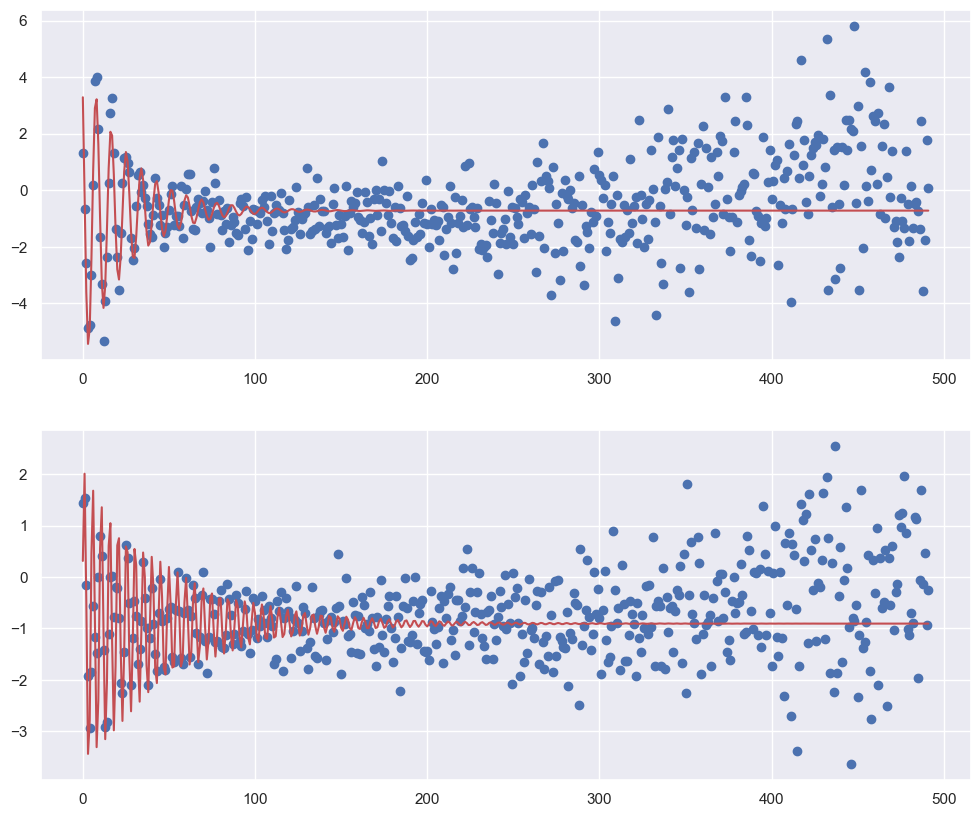

In [29]:
t = np.arange(492)
theoretical_values = pd.DataFrame()
for axis in 'XY':
    theoretical_values[axis] = function[axis](t)

fig, axs = plt.subplots(2, figsize=(12, 10))
axs[0].scatter(t, beam_center_coords['X'])
axs[0].plot(t, theoretical_values['X'], color='r')

axs[1].scatter(t, beam_center_coords['Y'])
axs[1].plot(t, theoretical_values['Y'], color='r');

Зададим некоторые параметры. Параметры хроматичности задаются автоматически на предыдущем шаге как значения амплитуд и хранятся в словаре chromacity. Данный словарь можно задать и вручную, просто переопределив переменную chromacity (пример в закомментированном коде). Параметр delta_impulse имеет формулу $dp/p_0$ и отвечает за отклонения импульсов от равновесного. На данном этапе, берется с установки

In [30]:
chromacity = {'X': 5.5, 'Y': 2.2}
delta_impulse = 2.5e-3

Проведем аппроксимацию для обеих осей и отобразим результаты графически

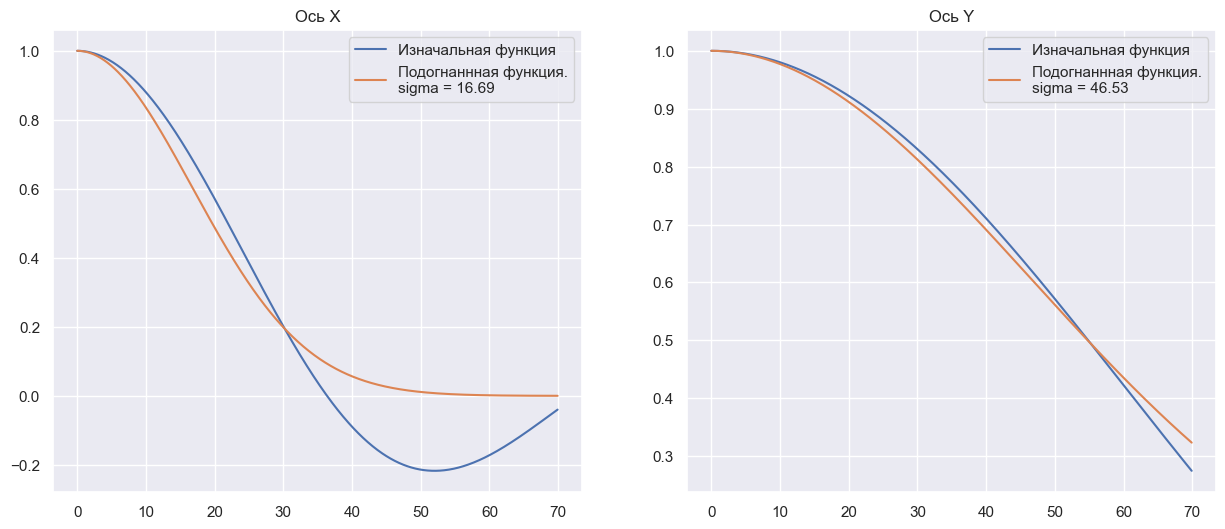

In [31]:
approximation_range = 70

result_function = {}
initial_function = {}
sigma = {}

for axis in 'XY':
    result_function[axis], initial_function[axis], sigma[axis] = pseudo_gaussian_exponent_approximation(chromacity[axis], delta_impulse, approximation_range)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

t = np.arange(0.01, approximation_range, 0.1)
axs[0].plot(t, initial_function['X'](t), label='Изначальная функция')
axs[0].plot(t, result_function['X'](t), label=f'Подогнаннная функция.\nsigma = {round(sigma["X"], 2)}')
axs[0].set_title('Ось X')
axs[0].legend()

axs[1].plot(t, initial_function['Y'](t), label='Изначальная функция')
axs[1].plot(t, result_function['Y'](t), label=f'Подогнаннная функция.\nsigma = {round(sigma["Y"], 2)}')
axs[1].set_title('Ось Y')
axs[1].legend();

## Спектр суммарного сигнала

Зададим некоторые параметры:
- offset - число значений, которые нужно пропустить от начала сигнала
- number_of_samples - число отступов для преобразования Фурье
- data_length - количество исходных данных
- time_delta - временной шаг

In [32]:
offset = 0
number_of_samples = 128 * 1024
data_length = len(data)
time_delta = (250 * 10**6)**(-1)

Вычислим значения спектра в первом окне, длиной number_of_samples и последнего окна, такой же длиной (первое окно берется из начала данны, последнее - из конца)

In [33]:
frequences, first_window_amplitudes = get_spectrum(
    summary_resonance['X'][offset: number_of_samples+offset] +\
    summary_resonance['Y'][offset: number_of_samples+offset],
    number_of_samples=number_of_samples, time_delta=time_delta)

frequences, last_window_amplitudes = get_spectrum(
    summary_resonance['X'][data_length-number_of_samples:] +\
    summary_resonance['Y'][data_length-number_of_samples:],
    number_of_samples=number_of_samples, time_delta=time_delta)

Построим графики спектров

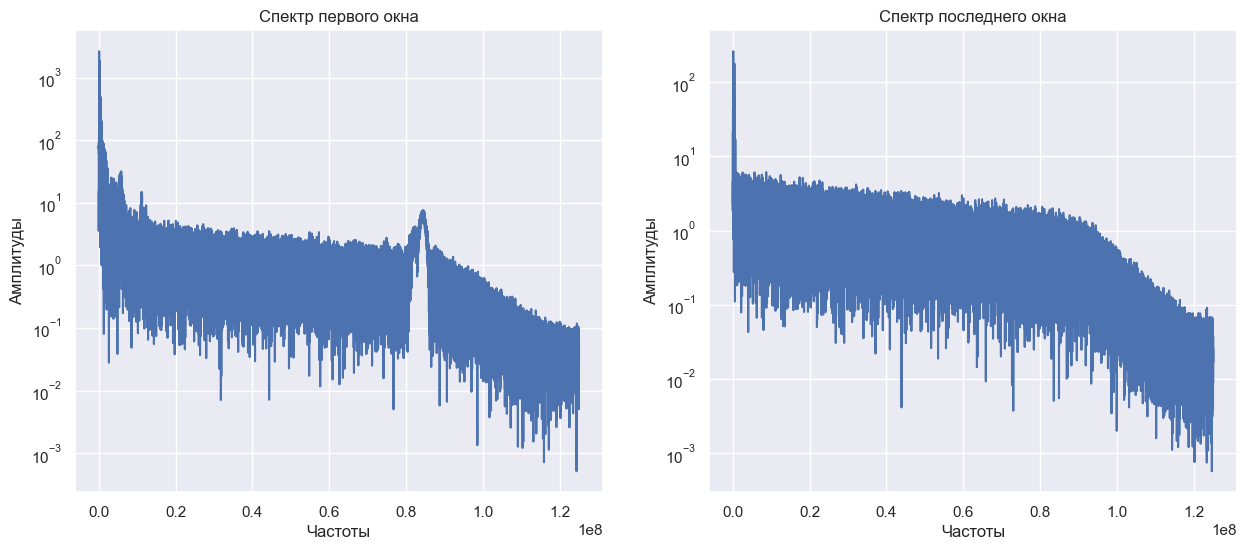

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(frequences, first_window_amplitudes)
axs[0].set_yscale('log')
axs[0].set_xlabel('Частоты')
axs[0].set_ylabel('Амплитуды')
axs[0].set_title('Спектр первого окна')

axs[1].plot(frequences, last_window_amplitudes)
axs[1].set_yscale('log')
axs[1].set_xlabel('Частоты')
axs[1].set_ylabel('Амплитуды')
axs[1].set_title('Спектр последнего окна');

Отфильтруем значения частот и амплитуд. Будем брать только те амплитуды, которые больше единицы. Это уберет часть шумов в спектре. Частоты возьмем за первые 10 оборотов

In [35]:
turnover_frequency = 1 / (time_delta * period) #Частота одного оборота

В данном случае, в каждом из условий мы получаем массив значений булевых значений вида [True, False, ..., False]. Eсли на позиции 10, например, находится False, это означает, что для элемента с номером 10 условие не выполняется. Для всех трех условий получаем такие массивы, после чего перемножаем их поэлементно, то есть применяем операцию логического "И" для каждого набора элементов, соответсвующих одному индексу. Таким образом, получаем булевый массив, значения которого показывают, удовлетворяет ли элемент на данной позиции всем трем условиям одновременно. Используя данный массив в качестве индекса, мы будем в дальнейшем производить фильтрацию.

In [36]:
filtered_indicies = (first_window_amplitudes > 1) * (last_window_amplitudes > 1) * (frequences < 10*turnover_frequency)

Построим график, на котором отразим уже фильтрованные сигналы

In [37]:
df = pd.DataFrame({
    'Frequences': frequences[filtered_indicies],
    'Амплитуды первого окна': first_window_amplitudes[filtered_indicies],
    'Амплитуды последнего окна': last_window_amplitudes[filtered_indicies],})

fig = px.line(df, x="Frequences", y=["Амплитуды первого окна", "Амплитуды последнего окна"], log_y=True)\
    .update_layout(xaxis_title='Частота', yaxis_title='Амплитуда', legend_title='Легенда')

fig.show()

Этот график является интерактивным. Визуально определяем, где на графики разность между пиками минимальна и наводимся туда курсором. Нам покажутся координаты этой точки. Нужна будет конкретно частота. Сохраним ее значение в переменную, которая пригодится нам в дальнейшем

In [38]:
frequence_with_minimal_difference = 427.246e3

## Коррекция АЧХ

Найдем округленный период и частоту, соответствующую ему

In [39]:
rounded_period = int(period)
rotation_frequency = 1 / (time_delta * rounded_period)

Реализуем передаточную функцию

In [40]:
time_constant_TF = 1 / frequence_with_minimal_difference
order = 1
transfer_function = lambda frequency: ((2j * np.pi * frequency * time_constant_TF) / (1 + 2j * np.pi * frequency * time_constant_TF)) ** order

Построим на графиках амплитуду и фазу передаточной функции для некоторого спектра частот

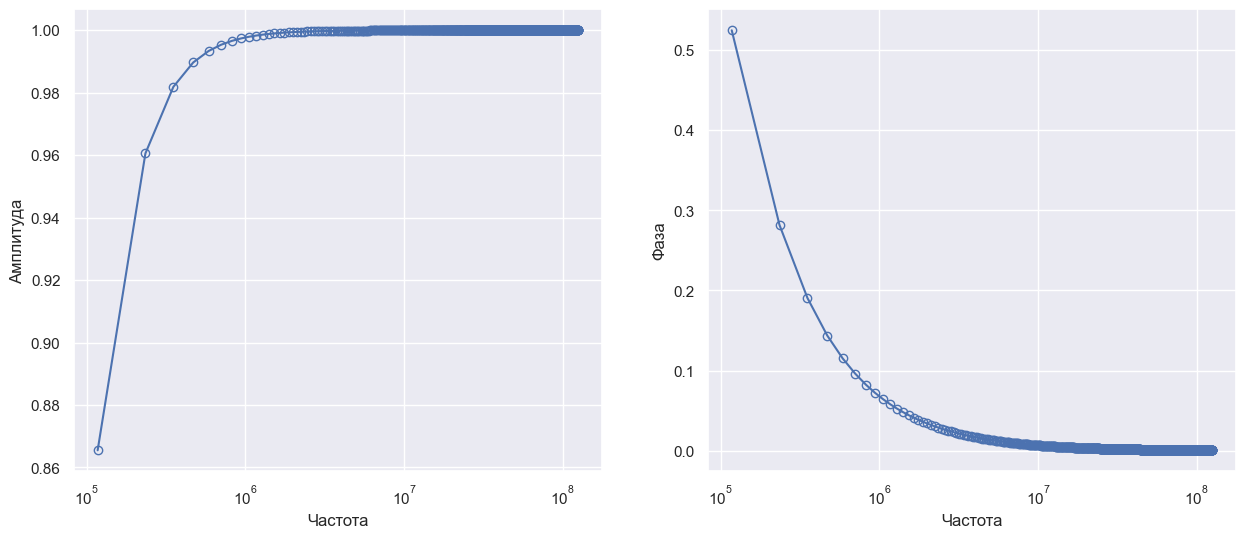

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
frequences_range = np.arange(1, rounded_period//2 + 1) * rotation_frequency

axs[0].plot(frequences_range, np.abs(transfer_function(frequences_range)), marker='o', mfc='None')
axs[0].set_xscale('log')
axs[0].set_xlabel('Частота')
axs[0].set_ylabel('Амплитуда')

axs[1].plot(frequences_range, np.angle(transfer_function(frequences_range)), marker='o', mfc='None')
axs[1].set_xscale('log')
axs[1].set_xlabel('Частота')
axs[1].set_ylabel('Фаза');

Произведем восстановление сигнала с последующей коррекцией

In [42]:
restored_signal = restore_original_signal_time_domain(summary_resonance['X'], period, rotation_frequency, transfer_function)
corrected_signal = correct_offset_with_smoothing(restored_signal, 60)

График суммарного сигнала по периодам

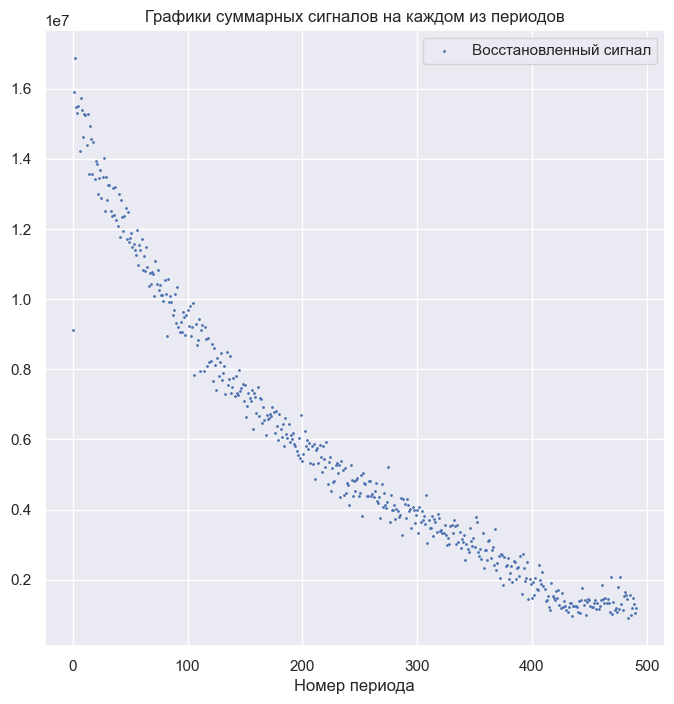

In [43]:
plt.figure(figsize=(8, 8))
plt.scatter(np.arange(492), [np.sum(bunch) for bunch in corrected_signal], s=1, label='Восстановленный сигнал')
plt.legend()
plt.title('Графики суммарных сигналов на каждом из периодов')
plt.xlabel('Номер периода');

Построим графики восстановленого сигнала для 1-ого, 2-ого и 21-ого периодов. Для наглядности, сделаем небольшие поправки к значениям

Text(0.5, 0, 't [ms]')

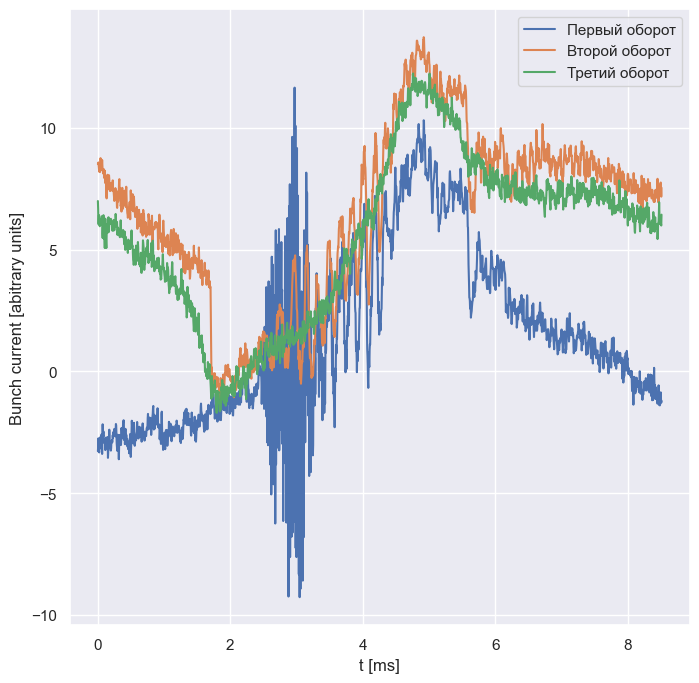

In [44]:
index_range = np.arange(1, int(period))

corrected_signal_0 = (corrected_signal[0][1:] / 10 ** 3) + index_range * 0.002 - 5
corrected_signal_1 = (corrected_signal[1][1:] / 10 ** 3) - index_range * 0.0009
corrected_signal_20 = (corrected_signal[20][1:] / 10 ** 3) - (index_range * 0.000 + 1)

time_range = 10**6 * time_delta * index_range

plt.figure(figsize=(8, 8))

plt.plot(time_range, corrected_signal_0, label='Первый оборот')
plt.plot(time_range, corrected_signal_1, label='Второй оборот')
plt.plot(time_range, corrected_signal_20, label='Третий оборот')

plt.legend()
plt.ylabel('Bunch current [abitrary units]')
plt.xlabel('t [ms]')

## Возбуждение пучка от удара

Сигнал, восстановленный в частотной области

In [45]:
frequency_domain_restored_signal = np.abs(restore_original_signal_frequency_domain(summary_resonance['X'], period, rotation_frequency, transfer_function))

Интерактивный график сигнала, восстановленного в частотной области для некоторых периодов

In [46]:
periods_on_plot = [0, 1, 2]
offset=20

plot_df = pd.DataFrame(frequency_domain_restored_signal[periods_on_plot, 1:int(period)//2+1].T, columns=[f'{i}-й период' for i in periods_on_plot])
plot_df['Frequences'] = frequences_range * 1e-6

fig = px.line(plot_df.iloc[offset:], x="Frequences", y=plot_df.drop('Frequences', axis=1).columns)\
    .update_layout(title='Графики сигналов, восстановленных в частотной области',xaxis_title='Частота, МГц', yaxis_title='Амплитуда', legend_title='Легенда')

fig.show()

Ограничим значения полностью восстановленного сигнала, чтобы увидеть его поведение на различных периодах

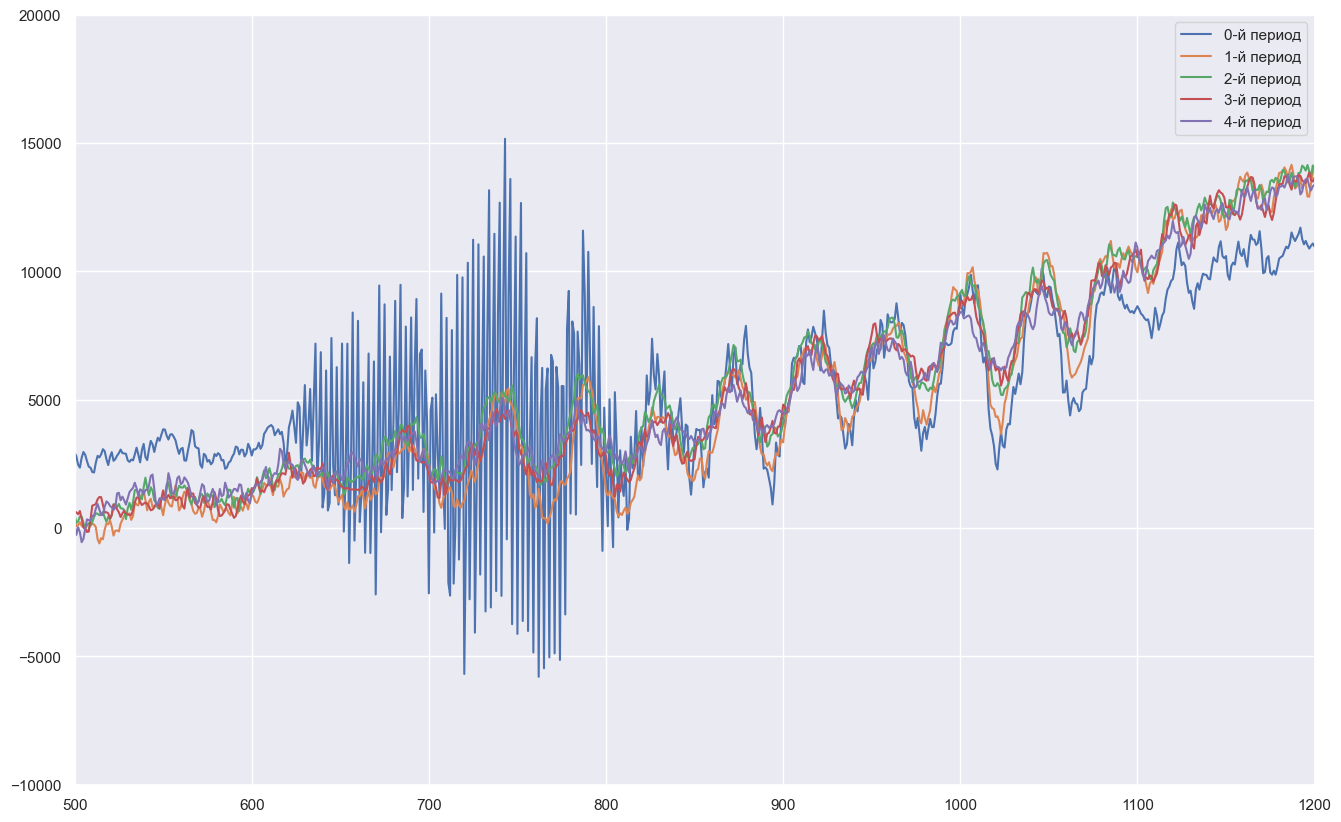

In [47]:
fig = plt.figure(figsize=(16, 10))
periods = [0, 1, 2, 3, 4] 

for i in periods:
    plt.plot(np.arange(len(corrected_signal[i])), corrected_signal[i], label=f'{i}-й период')

plt.legend()
plt.xlim([500, 1200])
plt.ylim([-1*10**4, 2*10**4]);

## Усреднение данных для томографии

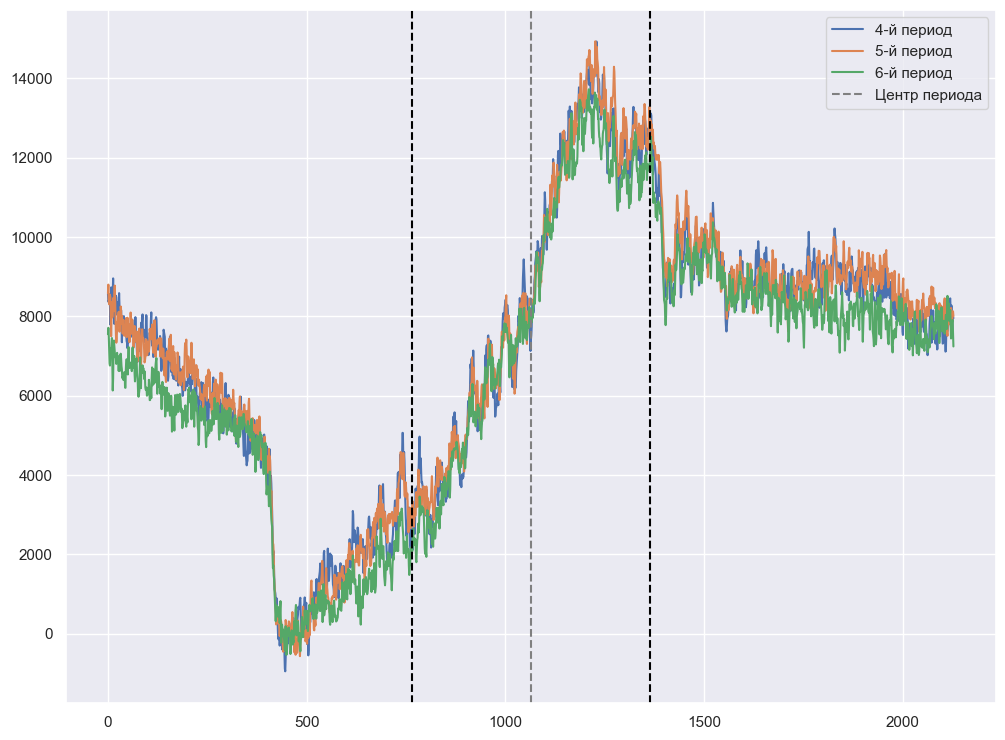

In [48]:
half_window_length = 300
periods_on_plot = [4, 5, 6]

plt.figure(figsize=(12, 9))

for period_number in periods_on_plot:
    plt.plot(corrected_signal[period_number], label=f'{period_number}-й период')

plt.axvline(int(period)//2 - half_window_length, ls='--', c='black')
plt.axvline(int(period)//2 + half_window_length, ls='--', c='black')
plt.axvline(int(period)//2, ls='--', c='gray', label='Центр периода')


plt.legend();

In [51]:
def convolve_bunched_signal(bunched_signal, kernel, stride=(1, 1), offset=0):
    return scipy.signal.convolve(corrected_signal[offset:], np.ones(convolution_kernel) / np.product(convolution_kernel), mode='valid')[::stride[0], ::stride[1]]

In [67]:
convolution_kernel = (5, 5)
convoluted_signal = convolve_bunched_signal(corrected_signal, convolution_kernel, (5, 5), 5)

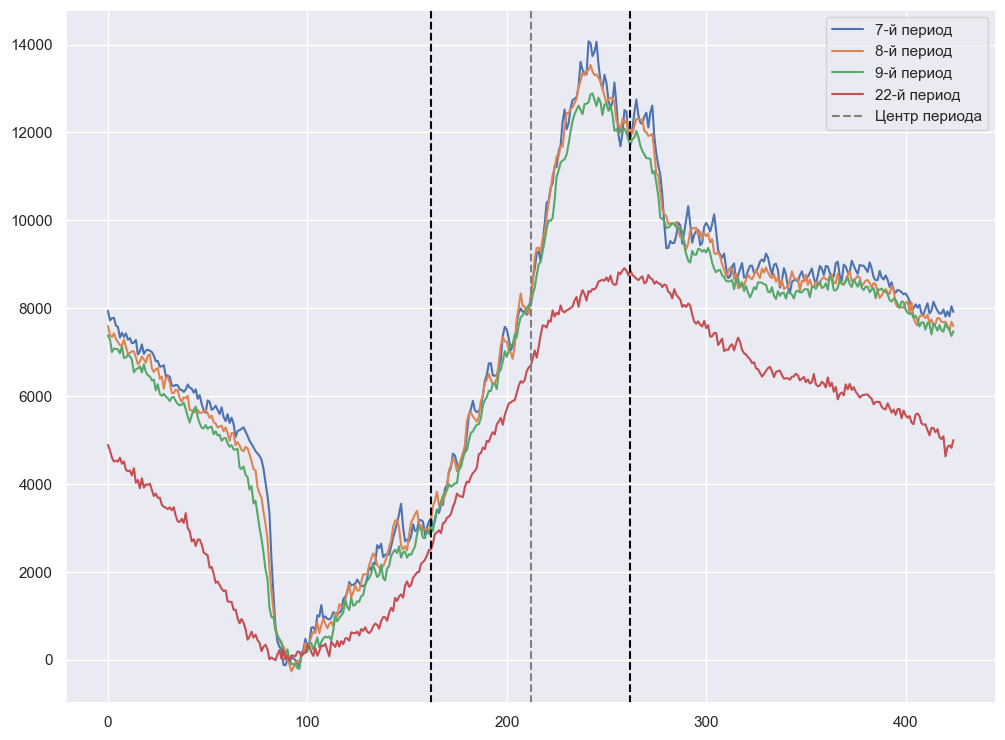

In [70]:
half_window_length = 50
periods_on_plot = [0, 1, 2, 15]

plt.figure(figsize=(12, 9))

for period_number in periods_on_plot:
    plt.plot(convoluted_signal[period_number], label=f'{period_number+7}-й период')

center = convoluted_signal.shape[1] // 2

plt.axvline(center - half_window_length, ls='--', c='black')
plt.axvline(center + half_window_length, ls='--', c='black')
plt.axvline(center, ls='--', c='gray', label='Центр периода')

plt.legend();

## Вычисление распределения

p_max - первое приближение отклонения по импульсу\
gamma - лоренц-фактор (с установки). 3.2 - энергия инжекциии, 938 - масса покоя протона\
eta - slip-factor\
alpha - коэфффициент расширения орбит\
N_p - разрешение по импульсному отклонению, 2*N_p+1 - окно импульсного отклонения\

In [54]:
first_period_index = 2
last_period_index = 10
momentum_deviation_resolution = 8

momentum_deviation_window_length = 2*momentum_deviation_resolution + 1

In [55]:
maximum_momentum_deviation = 4 * 10**(-3)
injection_energy = 3.2
proton_rest_mass = 938
orbit_expansion_factor = 0.0476

lorentz_factor = 1 + injection_energy / proton_rest_mass
slip_factor = 1 / lorentz_factor**2 - orbit_expansion_factor

In [64]:
number_of_periods_before_convolution = convolution_kernel[0] * (last_period_index - first_period_index)
momentum_deviations = maximum_momentum_deviation * (np.arange(momentum_deviation_window_length) - momentum_deviation_resolution) / momentum_deviation_resolution

array([-0.004 , -0.0035, -0.003 , -0.0025, -0.002 , -0.0015, -0.001 ,
       -0.0005,  0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025,
        0.003 ,  0.0035,  0.004 ])

In [85]:
convoluted_signal.shape[1]

425

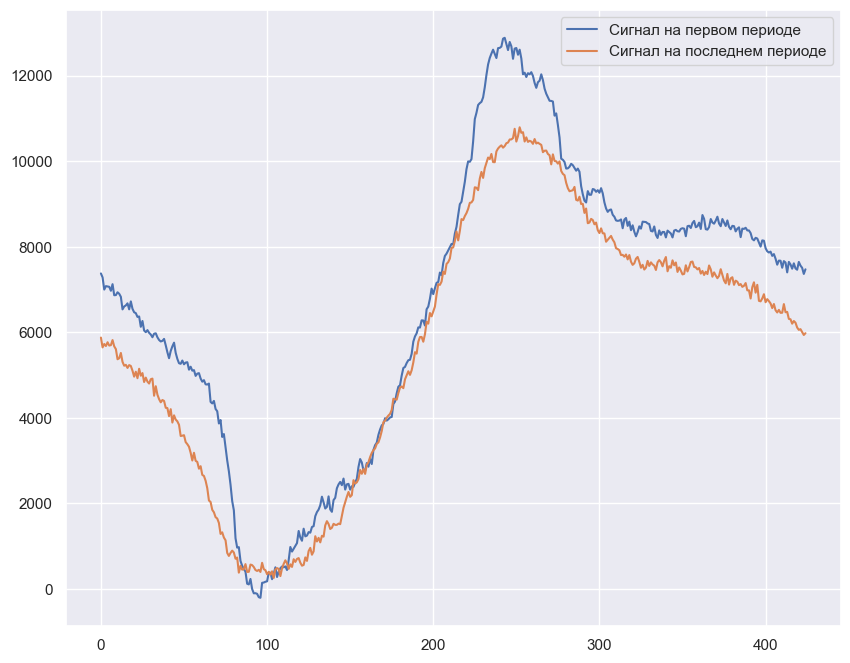

In [118]:
first_signal_moving_factor = 30*0
last_signal_moving_factor = 0.1

first_period_signal = convoluted_signal[first_period_index] - first_signal_moving_factor
last_period_signal = convoluted_signal[last_period_index]
last_period_signal = last_period_signal + last_signal_moving_factor * ((first_period_signal.sum() - last_period_signal.sum()) / convoluted_signal.shape[1])

plt.figure(figsize=(10, 8))
x = np.arange(convoluted_signal.shape[1])
plt.plot(x, first_period_signal, label='Сигнал на первом периоде')
plt.plot(x, last_period_signal, label='Сигнал на последнем периоде')
plt.legend();

In [119]:
p_np

array([-0.004 , -0.0035, -0.003 , -0.0025, -0.002 , -0.0015, -0.001 ,
       -0.0005,  0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025,
        0.003 ,  0.0035,  0.004 ])

In [124]:
def get_distr(pf, N_iter): 

    A = np.zeros(2 * N_p + 1)

    for k in range(N_iter + 1):
        for n in range(2 * N_p + 1):
            
            delta_f = pf - np.sum([A[i] * p_a[i] for i in range(2 * N_p + 1)], axis=0)

            A[n] += np.sum(delta_f @ p_a[n]) / np.sum(p_a[n]**2)

            A[n] = 0 if A[n] < 0 else A[n]
    
    return A

In [126]:
def shift_distr(ro, x, period):

    result_rt = []

    for iter in range(len(x)):
        S = scipy.fft.fft(ro) / len(ro)

        for k in range(len(S) // 2 + 1):
        
            S[k] = S[k] * np.exp((2j * np.pi) / period * x[iter] * k)

        for k in range(1, len(S) // 2):
            S[len(S)-k] = S[len(S)-k] * np.exp(-(2j * np.pi) / period * x[iter] * k)

        rt = (scipy.fft.ifft(S) * S.shape).real

        result_rt.append(rt)

    return result_rt

In [128]:
p_a = shift_distr(first_period_signal, slip_factor * np.arange(momentum_deviation_window_length) * convoluted_signal.shape[0] * 256, convoluted_signal.shape[0]) # работает верно
p_a

[array([ 7.37864067e+03,  7.28540567e+03,  7.00139791e+03,  7.08165689e+03,
         7.07290933e+03,  7.06561643e+03,  6.97339642e+03,  7.12783658e+03,
         6.86879177e+03,  6.87253303e+03,  6.93817288e+03,  6.90279740e+03,
         6.83200115e+03,  6.53789687e+03,  6.60604527e+03,  6.63063385e+03,
         6.67907468e+03,  6.53875599e+03,  6.72476012e+03,  6.55066050e+03,
         6.47023743e+03,  6.45036325e+03,  6.36178836e+03,  6.37219814e+03,
         6.13026928e+03,  6.26677920e+03,  6.04424352e+03,  6.00516698e+03,
         6.05308499e+03,  5.98951511e+03,  5.95006965e+03,  5.88646774e+03,
         5.96856818e+03,  5.97833844e+03,  5.88544676e+03,  5.82265843e+03,
         5.78786828e+03,  5.80188384e+03,  5.84755383e+03,  5.69829428e+03,
         5.53588701e+03,  5.39604509e+03,  5.56526859e+03,  5.67337772e+03,
         5.75963157e+03,  5.52116021e+03,  5.37956159e+03,  5.27854838e+03,
         5.26570165e+03,  5.34164703e+03,  5.25395126e+03,  5.29450101e+03,
         5.3

In [74]:

N_p1 = 2 # Первый оборот
N_p2 = 10 # Последний оборот
N_p = 8
p_max = 4 * 10**(-3)

gamma = 1 + 3.2 / 938
alfa = 0.0476

eta = 1 / gamma**2 - alfa

n_p = np.arange(2 * N_p + 1)
m_p = np.arange(2 * N_p + 1)

In [75]:
n_p

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [76]:
N_t = 5 * (N_p2 - N_p1) # Возможно возвращение к обратной размерности. Кол-во оборотов по размерности до свертки

p_np = p_max * (n_p - N_p) / N_p # Шкала импульсных отклонений

In [77]:
N_t

40

In [78]:
ro = convoluted_signal.T

In [79]:
ro_0 = ro[:, N_p1] - 30 # Начальный период. 30 тупо чтобы на графике не пересекались
ro_fin_0 = ro[:, N_p2] # Конечный период

In [87]:
L_p = 425

In [94]:
last_period_signal.sum()

2384308.058207248

In [96]:
last_period_signal

array([ 5773.10930521,  5543.21218105,  5622.9773496 ,  5575.79555756,
        5663.74396155,  5586.54861681,  5596.17283388,  5714.6803827 ,
        5568.33024421,  5503.25701104,  5266.33218879,  5288.98767358,
        5413.14754174,  5205.07069844,  5114.903445  ,  5135.37343887,
        5063.25802512,  5129.54799225,  5108.78437548,  4998.14350644,
        4859.39769598,  4974.63463458,  4822.64117628,  5043.74161616,
        4880.82704229,  4942.59475418,  4733.75559444,  4836.78310202,
        4742.87170698,  4698.09829186,  4799.32435952,  4813.74809972,
        4412.92090405,  4635.60351716,  4437.54879294,  4333.32320501,
        4259.36429899,  4312.91263438,  4291.86221111,  4131.56819236,
        4124.81322599,  3936.45205434,  4098.98981711,  3785.43913444,
        3954.69026822,  3856.12112882,  3813.61417706,  3733.67685033,
        3471.27510833,  3479.20901118,  3489.97771835,  3328.97332207,
        3280.32910226,  3219.9794703 ,  3078.94415431,  2898.235304  ,
      

In [95]:
ro_fin_0

array([ 5773.10930521,  5543.21218105,  5622.9773496 ,  5575.79555756,
        5663.74396155,  5586.54861681,  5596.17283388,  5714.6803827 ,
        5568.33024421,  5503.25701104,  5266.33218879,  5288.98767358,
        5413.14754174,  5205.07069844,  5114.903445  ,  5135.37343887,
        5063.25802512,  5129.54799225,  5108.78437548,  4998.14350644,
        4859.39769598,  4974.63463458,  4822.64117628,  5043.74161616,
        4880.82704229,  4942.59475418,  4733.75559444,  4836.78310202,
        4742.87170698,  4698.09829186,  4799.32435952,  4813.74809972,
        4412.92090405,  4635.60351716,  4437.54879294,  4333.32320501,
        4259.36429899,  4312.91263438,  4291.86221111,  4131.56819236,
        4124.81322599,  3936.45205434,  4098.98981711,  3785.43913444,
        3954.69026822,  3856.12112882,  3813.61417706,  3733.67685033,
        3471.27510833,  3479.20901118,  3489.97771835,  3328.97332207,
        3280.32910226,  3219.9794703 ,  3078.94415431,  2898.235304  ,
      

In [88]:
S1 = np.sum(ro_0) #Сум сигнал после преобразований
S2 = np.sum(ro_fin_0)

In [89]:
ro_fin = ro_fin_0 + 0.1 * ((S1 - S2) / L_p) # Чтобы поведение сигналов совпадало 0.1 тупо подгоняем

np.sum(ro_fin) # не сходится  ## сходится, но из-за костыля

2427950.1831036517

In [99]:
last_period_signal.sum()

2427950.1831036517